<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch01_CH03_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.losses as losses


In [3]:
'''
y_true =          0   1  1   0
y_pred =          0.5 1 0.2 0.3
y_true * y_pred = 0   1 0.2  0 -> reduce_sum = 1.2 -> 1.2 pixel 겹침
'''

def iou(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    score = intersection / (union + smooth)
    return score

def dice_coef(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection )/ ( tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)

    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 1. * losses.binary_crossentropy(y_true, y_pred) + 1. * dice_loss(y_true, y_pred)

    return loss


In [4]:
import albumentations as A
import cv2

class Augmentation:
  def __init__(self, size, mode ='train'):
    if mode =='train':
      # Declare an augmentation pipeline
      self.transform = A.Compose([
          A.HorizontalFlip(p=0.5), # 좌우반전, p(적용할 확률)
          A.ShiftScaleRotate(
              p = 0.5,
              shift_limit = 0.05,
              scale_limit = 0.05,
              rotate_limit = 15,
          ), # 이동%, 확대축소%, 회전각도 제약걸기
          A.CoarseDropout(
              p = 0.5,
              max_holes =8,
              max_height = int(0.1 * size),
              max_width = int(0.1 * size),
          ),
          A.RandomBrightnessContrast(p=0.2),
      ])

  def __call__(self, **kwargs):
    if self.transform:
      aumented = self.transform(**kwargs)
      img = aumented['image']
      mask = aumented['mask']

      return img, mask


In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        batch_size,
        csv_path,
        fold,
        image_size,
        mode ='train',
        shuffle = True):

        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode =='val':
            self.df = self.df[self.df['fold'] == self.fold]


        ### Remove invalid files
        ### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['filename'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)

        self.on_epoch_end()


    def __len__(self):
        return math.ceil(len(self.df)/self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1)* self.batch_size
        data = self.df.iloc[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x =[]
        batch_y =[]

        for _, r in data.iterrows():
            file_name = r['filename']

            image = cv2.imread(f'/content/drive/MyDrive/data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # input image resize (배치로 묶기위해)
            image = cv2.resize(image, (self.image_size, self.image_size))

            # mask가 Label 로 사용
            mask = cv2.imread(f'/content/drive/MyDrive/data/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] =0

            if self.mode == 'train':
            #   image = image.astype('uint8')
              image, mask= self.transform(image = image,
                                     mask = mask)

            # rescaling
            image = image.astype('float32')
            image = image /255.

            mask = mask.astype('float32')

            # mask가 Label 로 사용
            batch_x.append(image)
            batch_y.append(mask)
        return batch_x, batch_y



    def on_epoch_end(self): # callback function
        if self.shuffle:
            self.df = self.df.sample(frac =1).reset_index(drop=True)

csv_path = '/content/drive/MyDrive/data/kfolds.csv'
train_generator = DataGenerator(
    batch_size = 64,
    csv_path =csv_path,
    fold = 1,
    image_size = 128,
    mode ='train',
    shuffle = True
)

val_generator = DataGenerator(
    batch_size = 64,
    csv_path =csv_path,
    fold = 1,
    image_size = 128,
    mode ='val',
    shuffle = True
)

In [8]:
!pip install keras_unet

In [9]:
#https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=True,
    upsample_mode= 'deconv',
    dropout_type='spatial',
    use_attention = True,
    num_classes=1,
    filters=64,
    num_layers =4,
    dropout=0.2,
    output_activation='sigmoid')

model.compile(optimizer = 'adam', loss = bce_dice_loss, metrics =[iou])
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1728      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                               

In [10]:
help(custom_unet)

Help on function custom_unet in module keras_unet.models.custom_unet:

custom_unet(input_shape, num_classes=1, activation='relu', use_batch_norm=True, upsample_mode='deconv', dropout=0.3, dropout_change_per_layer=0.0, dropout_type='spatial', use_dropout_on_upsampling=False, use_attention=False, filters=16, num_layers=4, output_activation='sigmoid')
    Customisable UNet architecture (Ronneberger et al. 2015 [1]).
    
    Arguments:
    input_shape: 3D Tensor of shape (x, y, num_channels)
    
    num_classes (int): Unique classes in the output mask. Should be set to 1 for binary segmentation
    
    activation (str): A keras.activations.Activation to use. ReLu by default.
    
    use_batch_norm (bool): Whether to use Batch Normalisation across the channel axis between convolutional layers
    
    upsample_mode (one of "deconv" or "simple"): Whether to use transposed convolutions or simple upsampling in the decoder part
    
    dropout (float between 0. and 1.): Amount of dropout a

In [11]:
history = model.fit(
    train_generator ,
    validation_data = val_generator,
    epochs = 20,
    verbose =1
)

Epoch 1/20
92/92 [==============================] - 3172s 34s/step - loss: 0.9152 - iou: 0.4184 - val_loss: 6.4554 - val_iou: 0.3758
Epoch 2/20
92/92 [==============================] - 130s 1s/step - loss: 0.6516 - iou: 0.5408 - val_loss: 1.5293 - val_iou: 0.5468
Epoch 3/20
92/92 [==============================] - 130s 1s/step - loss: 0.5506 - iou: 0.5991 - val_loss: 0.8843 - val_iou: 0.6428
Epoch 4/20
92/92 [==============================] - 129s 1s/step - loss: 0.4906 - iou: 0.6377 - val_loss: 0.6214 - val_iou: 0.6646
Epoch 5/20
92/92 [==============================] - 131s 1s/step - loss: 0.4623 - iou: 0.6559 - val_loss: 0.4701 - val_iou: 0.7170
Epoch 6/20
92/92 [==============================] - 136s 1s/step - loss: 0.4363 - iou: 0.6725 - val_loss: 0.4413 - val_iou: 0.7072
Epoch 7/20
92/92 [==============================] - 130s 1s/step - loss: 0.4184 - iou: 0.6839 - val_loss: 0.4079 - val_iou: 0.7424
Epoch 8/20
92/92 [==============================] - 132s 1s/step - loss: 0.4055 -

<function matplotlib.pyplot.show(close=None, block=None)>

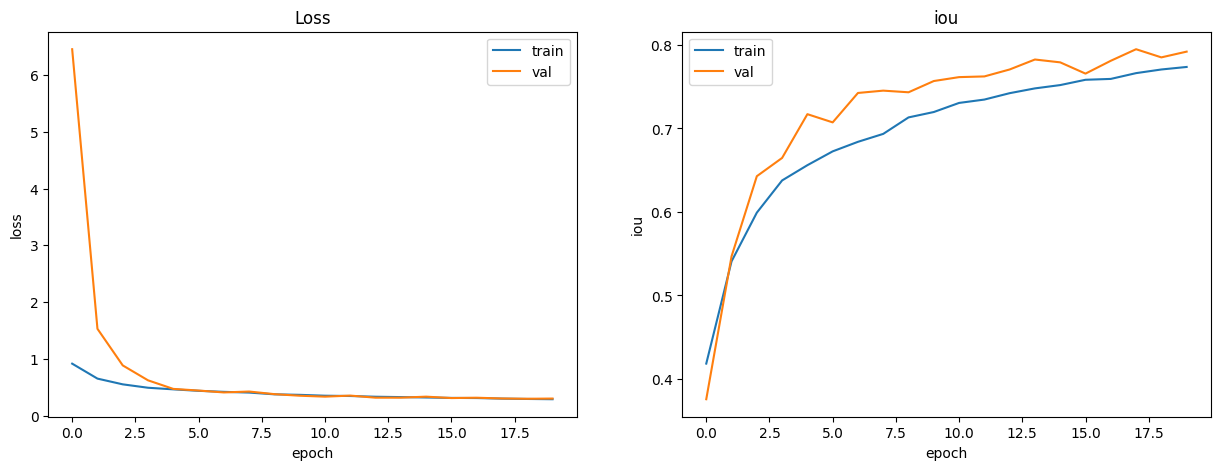

In [14]:
import matplotlib.pyplot as plt
# history = history.history

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label ='train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['iou'], label ='train')
plt.plot(history['val_iou'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title('iou')
plt.show


In [17]:
for image, masks in val_generator:
    break

In [18]:
preds = model.predict(image)

2/2 [==============================] - 7s 38ms/step


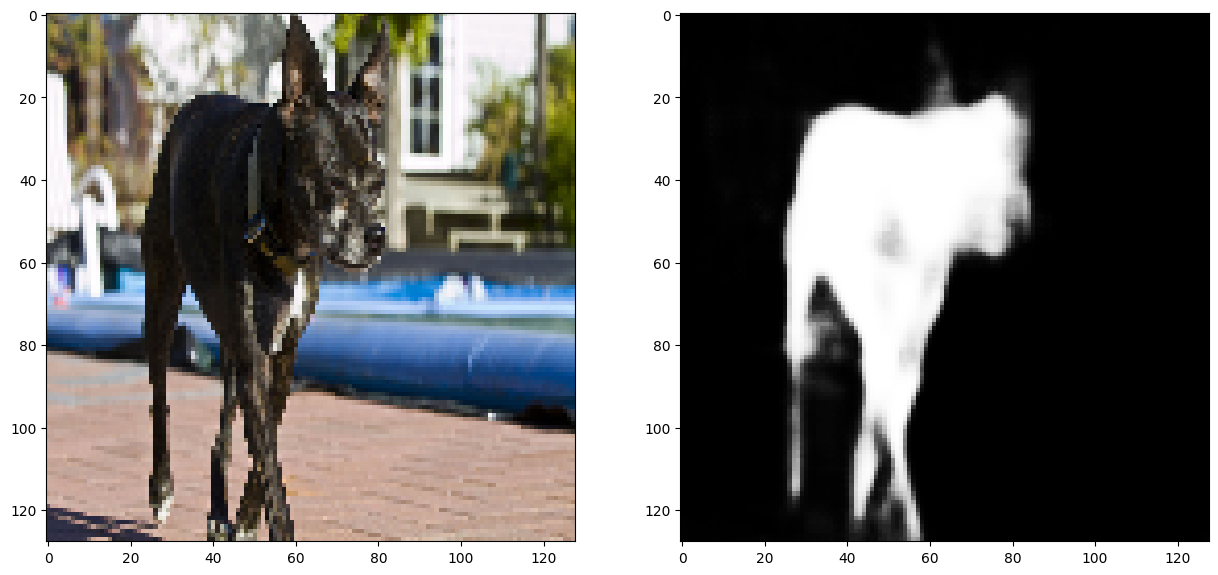

In [21]:
import random
idx = random.choices(range(len(preds)))
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(image[idx, ...][0])
plt.subplot(1,2,2)
plt.imshow(preds[idx, ...][0], cmap = 'gray')

plt.show()